# Detección de objetos con TensorFlow Hub (EfficientDet)

En este notebook pruebo **detección de objetos** usando un modelo **EfficientDet** ya preentrenado (viene de **TensorFlow Hub**) y entrenado en **COCO 2017**.

**Qué vas a ver acá:**
- Descargar imágenes de ejemplo (para probar rápido)
- Elegir variante del modelo (D0…D7) según potencia/tiempo
- Correr inferencia y entender la salida del modelo
- Dibujar bounding boxes + clase + confianza
- (Extra) Subir tus propias imágenes desde la PC y ver los resultados

> Ojo: las variantes grandes (D7) son pesadas. Si estás en CPU o te va lento, usá D0/D1/D2.


## 1) Setup

Importo librerías y bajo el ruido de logs (Colab a veces se pone denso con warnings).


In [1]:
import os
import glob as glob
import zipfile
import requests
import numpy as np
import cv2

import tensorflow_hub as hub

import matplotlib.pyplot as plt
import warnings
import logging
import absl

# --- Logs prolijos ---
warnings.filterwarnings('ignore', module='absl')
logging.captureWarnings(True)
logging.getLogger('absl').setLevel(logging.ERROR)

# Menos spam de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


## 2) Descargar imágenes de ejemplo

Para no depender de un dataset local, bajo un zip con imágenes de prueba.


In [2]:
def download_file(url: str, save_name: str) -> None:
    '''Descarga un archivo por HTTP y lo guarda localmente.'''
    r = requests.get(url)
    r.raise_for_status()
    with open(save_name, 'wb') as f:
        f.write(r.content)


def unzip(zip_file: str, out_dir: str = './') -> None:
    '''Descomprime un zip en la carpeta indicada.'''
    with zipfile.ZipFile(zip_file) as z:
        z.extractall(out_dir)
    print('Extraído:', zip_file)


In [3]:
download_file(
    'https://www.dropbox.com/s/h7l1lmhvga6miyo/object_detection_images.zip?dl=1',
    'object_detection_images.zip'
)

unzip('object_detection_images.zip', out_dir='./')


Extraído: object_detection_images.zip


## 3) Cargar y mostrar algunas imágenes

Leo algunas imágenes y las muestro en grilla para tener una idea de lo que vamos a detectar.


In [4]:
image_paths = sorted(glob.glob('object_detection_images/*.png'))
print('Cantidad de imágenes:', len(image_paths))
for p in image_paths[:10]:
    print('-', p)


Cantidad de imágenes: 4
- object_detection_images/dog_bicycle_car.png
- object_detection_images/elephants.png
- object_detection_images/home_interior.png
- object_detection_images/place_setting.png


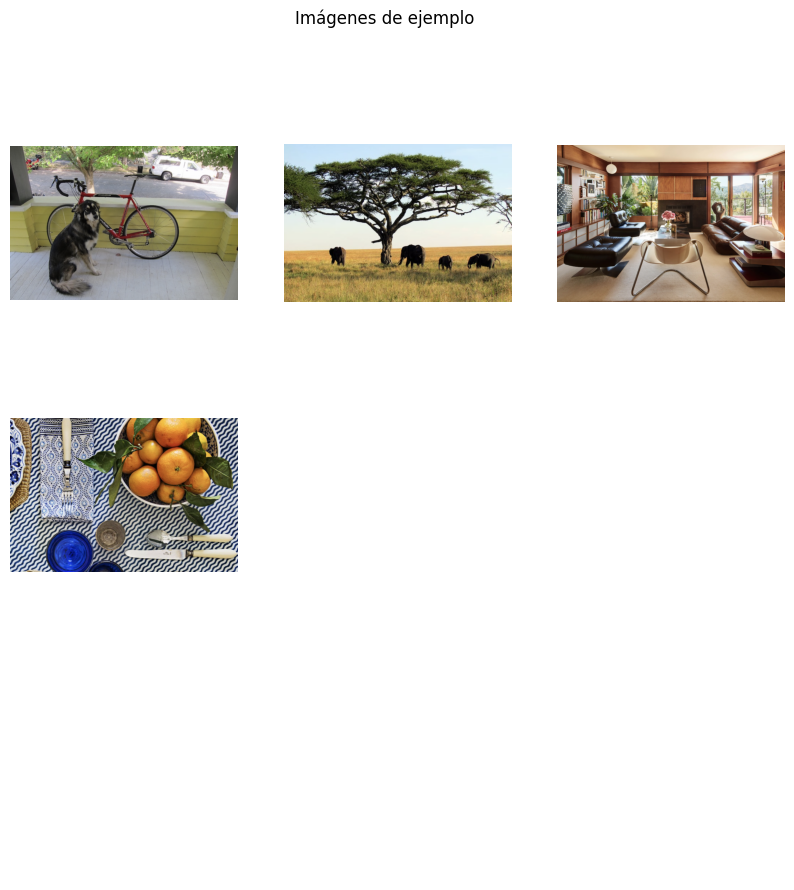

In [5]:
def show_grid(images, nrows=3, ncols=3, figsize=(10, 10), title=None):
    '''Muestra una grilla simple de imágenes (batch opcional).'''
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    if title:
        fig.suptitle(title)

    idx = 0
    for axis in ax.flat:
        if idx >= len(images):
            axis.axis('off')
            continue
        img = images[idx]
        # Si viene como [1,H,W,3] lo saco
        if img.ndim == 4:
            img = np.squeeze(img, axis=0)
        axis.imshow(img)
        axis.axis('off')
        idx += 1
    plt.show()


def load_image_rgb(path: str) -> np.ndarray:
    '''Carga una imagen (RGB) y devuelve un batch [1,H,W,3] en uint8.'''
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise ValueError(f'No pude leer la imagen: {path}')
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return np.expand_dims(img_rgb, axis=0)


# Cargo 9 imágenes para la demo
images = [load_image_rgb(p) for p in image_paths[:9]]
show_grid(images, title='Imágenes de ejemplo')


## 4) Diccionario de clases (COCO)

COCO tiene 90 clases (algunas IDs están salteadas). Este diccionario mapea **id → nombre**.


In [6]:
class_index = {
    1: 'persona',
    2: 'bicicleta',
    3: 'auto',
    4: 'moto',
    5: 'avión',
    6: 'colectivo',
    7: 'tren',
    8: 'camión',
    9: 'barco',
    10: 'semáforo',
    11: 'hidrante',
    13: 'señal de pare',
    14: 'parquímetro',
    15: 'banco',
    16: 'pájaro',
    17: 'gato',
    18: 'perro',
    19: 'caballo',
    20: 'oveja',
    21: 'vaca',
    22: 'elefante',
    23: 'oso',
    24: 'cebra',
    25: 'jirafa',
    27: 'mochila',
    28: 'paraguas',
    31: 'cartera',
    32: 'corbata',
    33: 'valija',
    34: 'frisbee',
    35: 'esquís',
    36: 'tabla de snowboard',
    37: 'pelota',
    38: 'barrilete',
    39: 'bate de béisbol',
    40: 'guante de béisbol',
    41: 'skate',
    42: 'tabla de surf',
    43: 'raqueta de tenis',
    44: 'botella',
    46: 'copa de vino',
    47: 'taza',
    48: 'tenedor',
    49: 'cuchillo',
    50: 'cuchara',
    51: 'bol',
    52: 'banana',
    53: 'manzana',
    54: 'sándwich',
    55: 'naranja',
    56: 'brócoli',
    57: 'zanahoria',
    58: 'pancho',
    59: 'pizza',
    60: 'dona',
    61: 'torta',
    62: 'silla',
    63: 'sillón',
    64: 'planta en maceta',
    65: 'cama',
    67: 'mesa',
    70: 'inodoro',
    72: 'tele',
    73: 'notebook',
    74: 'mouse',
    75: 'control remoto',
    76: 'teclado',
    77: 'celular',
    78: 'microondas',
    79: 'horno',
    80: 'tostadora',
    81: 'pileta',
    82: 'heladera',
    84: 'libro',
    85: 'reloj',
    86: 'florero',
    87: 'tijeras',
    88: 'osito de peluche',
    89: 'secador de pelo',
    90: 'cepillo de dientes'
}


In [7]:
# Mapeo simple: id de clase → color RGB (para bbox)
R = np.array(np.arange(96, 256, 32))
G = np.roll(R, 1)
B = np.roll(R, 2)
COLOR_IDS = np.array(np.meshgrid(R, G, B)).T.reshape(-1, 3)


## 5) Elegir y cargar un modelo EfficientDet

Las variantes D0…D7 cambian principalmente:
- **tamaño de entrada** (cuadrado)
- **velocidad**
- **calidad**

En general: **D0/D1** para rápido, **D4** balance, **D7** si tenés GPU y paciencia.


In [8]:
EfficientDet  = {'EfficientDet D0 512x512'   : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
                 'EfficientDet D1 640x640'   : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
                 'EfficientDet D2 768x768'   : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
                 'EfficientDet D3 896x896'   : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
                 'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
                 'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
                 'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
                 'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1'
                }


In [9]:
# Elegí el modelo acá (cambiá el string por el que quieras)
MODEL_NAME = 'EfficientDet D0 512x512'   # recomendado como balance
# MODEL_NAME = 'EfficientDet D0 512x512'   # rápido
# MODEL_NAME = 'EfficientDet D7 1536x1536' # pesado

# Tamaño esperado por variante (cuadrado)
MODEL_INPUT_SIZE = {
    'EfficientDet D0 512x512': 512,
    'EfficientDet D1 640x640': 640,
    'EfficientDet D2 768x768': 768,
    'EfficientDet D3 896x896': 896,
    'EfficientDet D4 1024x1024': 1024,
    'EfficientDet D5 1280x1280': 1280,
    'EfficientDet D6 1280x1280': 1280,
    'EfficientDet D7 1536x1536': 1536,
}

model_url = EfficientDet[MODEL_NAME]
input_size = MODEL_INPUT_SIZE[MODEL_NAME]

print('Modelo:', MODEL_NAME)
print('URL:', model_url)
print('Input size:', input_size)

print('Cargando modelo...')
model = hub.load(model_url)
print('Modelo cargado')


Modelo: EfficientDet D0 512x512
URL: https://tfhub.dev/tensorflow/efficientdet/d0/1
Input size: 512
Cargando modelo...
Modelo cargado


## 6) Preparar imágenes para el modelo (resize “bien”)

EfficientDet espera imágenes cuadradas (por ejemplo 1024×1024). Para no deformar la imagen:
- hago **letterbox** (resize manteniendo aspecto + padding negro)

Esto mantiene la geometría y hace que los boxes tengan sentido visual.


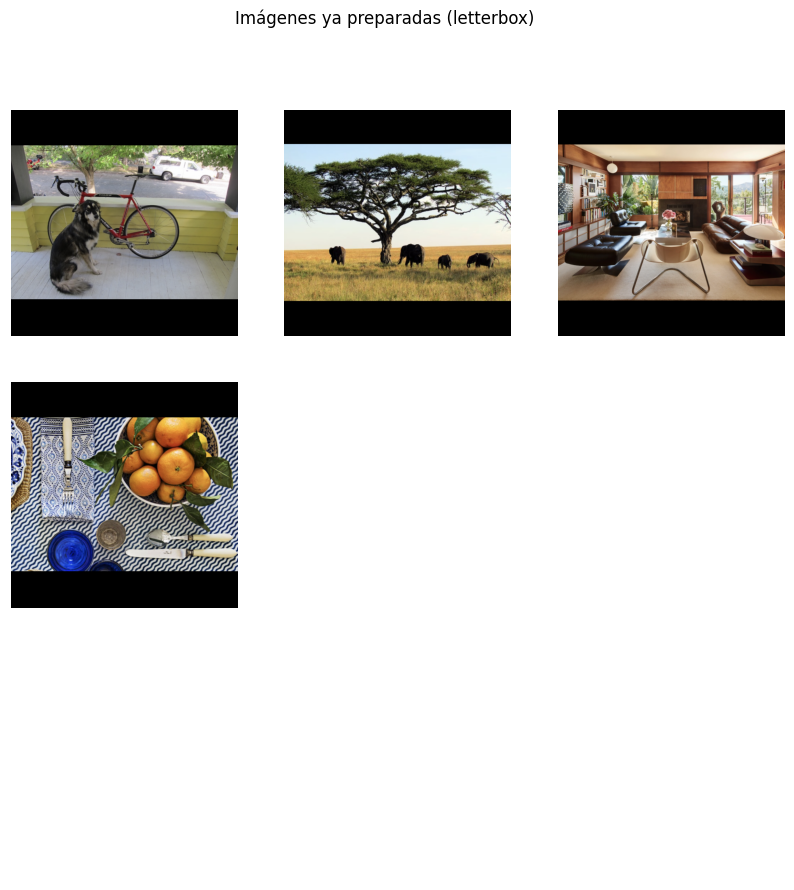

In [10]:
def letterbox_to_square(img_rgb: np.ndarray, size: int, pad_value: int = 0) -> np.ndarray:
    '''Resize manteniendo aspecto y padding hasta (size,size).'''
    h, w = img_rgb.shape[:2]
    scale = min(size / w, size / h)
    new_w = max(1, int(round(w * scale)))
    new_h = max(1, int(round(h * scale)))

    resized = cv2.resize(
        img_rgb,
        (new_w, new_h),
        interpolation=cv2.INTER_AREA if scale < 1 else cv2.INTER_LINEAR,
    )

    canvas = np.full((size, size, 3), pad_value, dtype=np.uint8)
    top = (size - new_h) // 2
    left = (size - new_w) // 2
    canvas[top:top + new_h, left:left + new_w] = resized
    return canvas


def load_image_for_model(path: str, input_size: int) -> np.ndarray:
    '''Carga una imagen desde disco y la devuelve como batch [1,size,size,3] en uint8.'''
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise ValueError(f'No pude leer la imagen: {path}')
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    img_sq = letterbox_to_square(img_rgb, size=input_size, pad_value=0)
    return np.expand_dims(img_sq, axis=0)


# Re-cargo las 9 imágenes pero ya adaptadas al input del modelo
images_model = [load_image_for_model(p, input_size) for p in image_paths[:9]]
show_grid(images_model, title='Imágenes ya preparadas (letterbox)')


## 7) Inferencia rápida en una imagen + ver la salida

El modelo devuelve un diccionario con varias keys. A nosotros nos interesan principalmente:
- `detection_boxes`
- `detection_classes`
- `detection_scores`
- `num_detections`

(El resto suele ser info interna / raw detections.)


In [11]:
results = model(images_model[0])
results = {k: v.numpy() for k, v in results.items()}

print('Keys devueltas por el modelo:')
for k in results:
    print('-', k)

print('Num detections (post-procesadas):', int(results['num_detections'][0]))
print('Ejemplo scores (primeros 5):', results['detection_scores'][0][:5])


Keys devueltas por el modelo:
- raw_detection_boxes
- detection_multiclass_scores
- detection_classes
- detection_boxes
- raw_detection_scores
- num_detections
- detection_anchor_indices
- detection_scores
Num detections (post-procesadas): 100
Ejemplo scores (primeros 5): [0.84380984 0.7605321  0.7492145  0.29670033 0.24832043]


## 8) Post-proceso: dibujar bounding boxes + etiqueta

Acá filtramos por una **confianza mínima** (`min_det_thresh`) y dibujamos:
- rectángulo
- texto: clase + %

La idea es que puedas ajustar el umbral según tu caso.


In [12]:
def process_detection(image_rgb: np.ndarray, results: dict, min_det_thresh: float = 0.3) -> np.ndarray:
    '''
    Dibuja bounding boxes sobre `image_rgb` usando la salida de EfficientDet.

    Params:
      - image_rgb: imagen sin batch [H,W,3]
      - results: dict con detection_boxes/classes/scores
      - min_det_thresh: umbral de confianza (0..1)

    Returns:
      - imagen anotada (RGB)
    '''
    scores = results['detection_scores'][0]
    boxes = results['detection_boxes'][0]
    classes = results['detection_classes'][0].astype(int)

    det_indices = np.where(scores >= min_det_thresh)[0]

    img_bbox = image_rgb.copy()
    h, w = img_bbox.shape[:2]

    # Ajuste "automático" para que el texto no quede gigante/chico según la imagen
    font_scale = max(0.6, min(1.2, (w / 1024)))
    box_thickness = max(2, int(round(w / 400)))
    text_thickness = max(1, int(round(w / 800)))

    for idx in det_indices:
        ymin, xmin, ymax, xmax = boxes[idx]
        class_id = classes[idx]
        score = float(scores[idx])

        class_name = class_index.get(class_id, f'clase_{class_id}')

        left = int(xmin * w)
        right = int(xmax * w)
        top = int(ymin * h)
        bottom = int(ymax * h)

        # Color (BGR para OpenCV)
        color_rgb = COLOR_IDS[class_id % len(COLOR_IDS)].tolist()
        color_bgr = tuple(color_rgb[::-1])

        img_bbox = cv2.rectangle(img_bbox, (left, top), (right, bottom), color_bgr, thickness=box_thickness)

        label = f'{class_name}: {score*100:.1f}%'
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_thickness)

        # Fondo del label (arriba del bbox si se puede)
        y0 = top - th - 10
        if y0 < 0:
            y0 = top + 10

        img_bbox = cv2.rectangle(
            img_bbox,
            (left, y0),
            (left + tw + 10, y0 + th + 10),
            color_bgr,
            thickness=-1,
        )

        img_bbox = cv2.putText(
            img_bbox,
            label,
            (left + 5, y0 + th + 3),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (0, 0, 0),
            text_thickness,
            cv2.LINE_AA,
        )

    return img_bbox


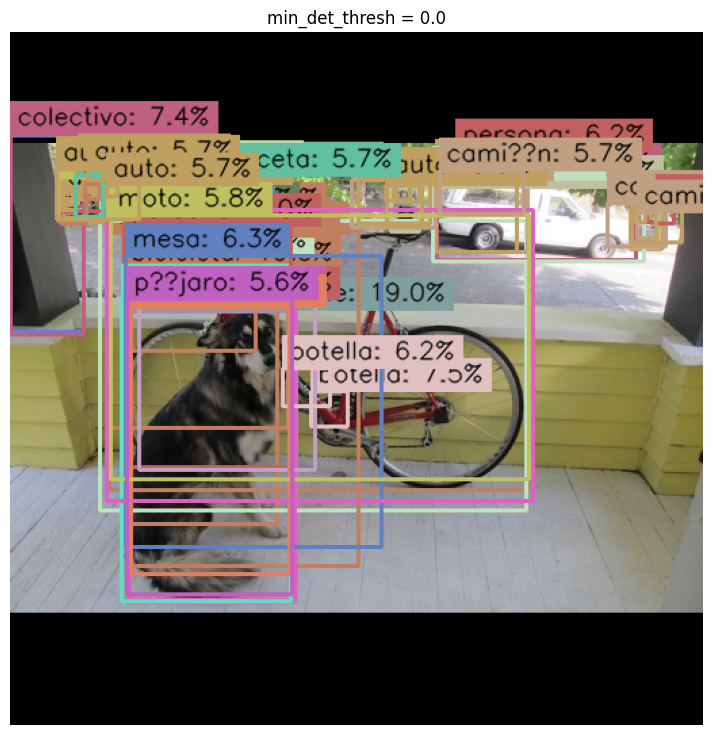

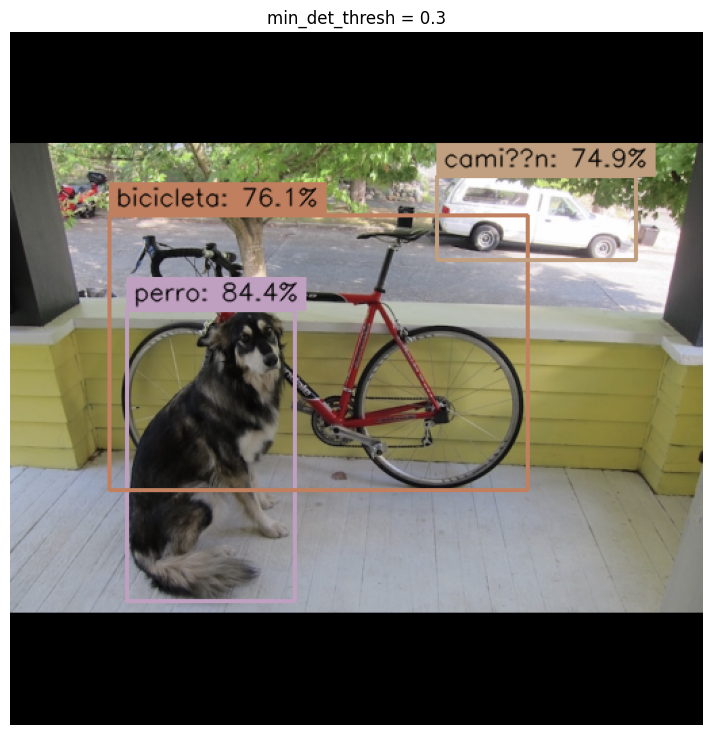

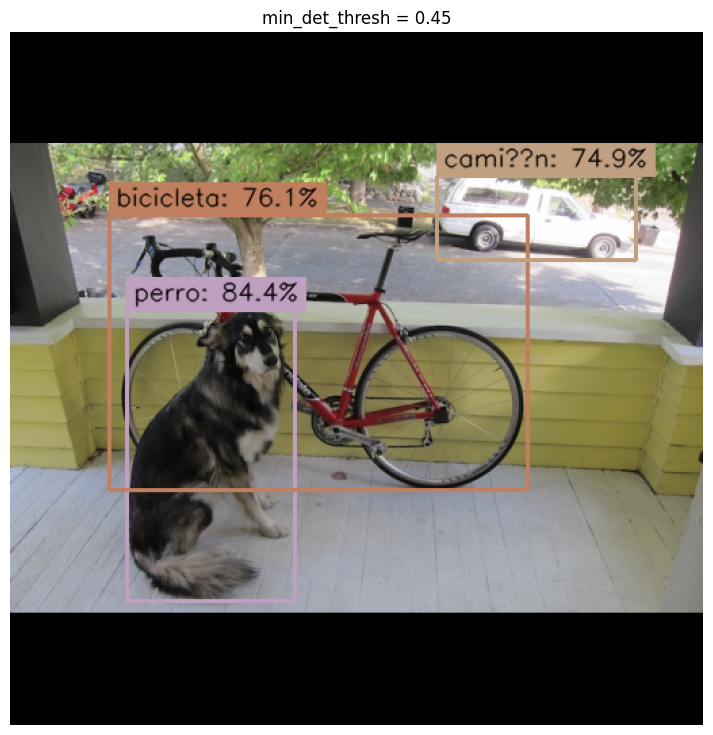

In [13]:
# Probamos con distintos umbrales en una sola imagen
image0 = np.squeeze(images_model[0])

for thr in [0.0, 0.3, 0.45]:
    img_bbox = process_detection(image0, results, min_det_thresh=thr)
    plt.figure(figsize=(14, 9))
    plt.title(f'min_det_thresh = {thr}')
    plt.imshow(img_bbox)
    plt.axis('off')
    plt.show()


## 9) Inferencia en batch (varias imágenes)

Función helper para correr el modelo sobre una lista de imágenes (batch 1 por vez).


In [14]:
def run_inference(images_batched, model):
    '''Corre inferencia para cada imagen (cada una viene como [1,H,W,3]).'''
    results_list = []
    for img in images_batched:
        res = model(img)
        res = {k: v.numpy() for k, v in res.items()}
        results_list.append(res)
    return results_list


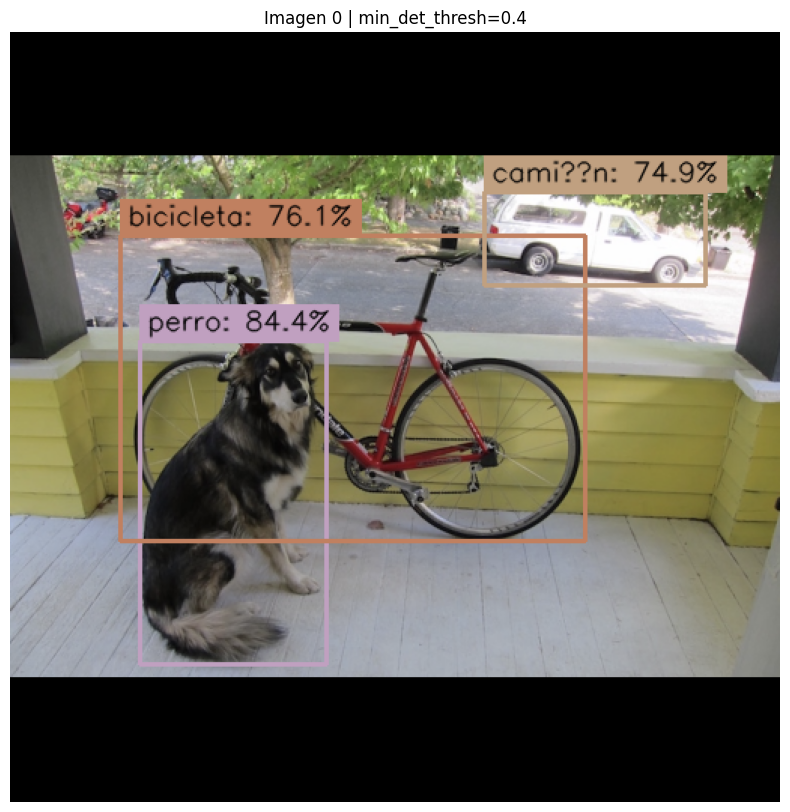

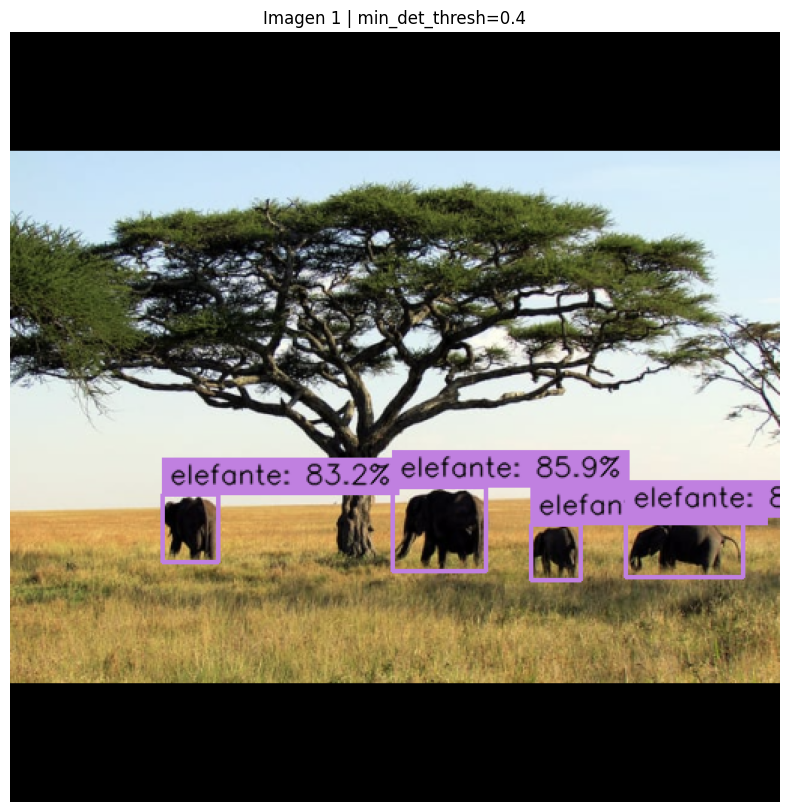

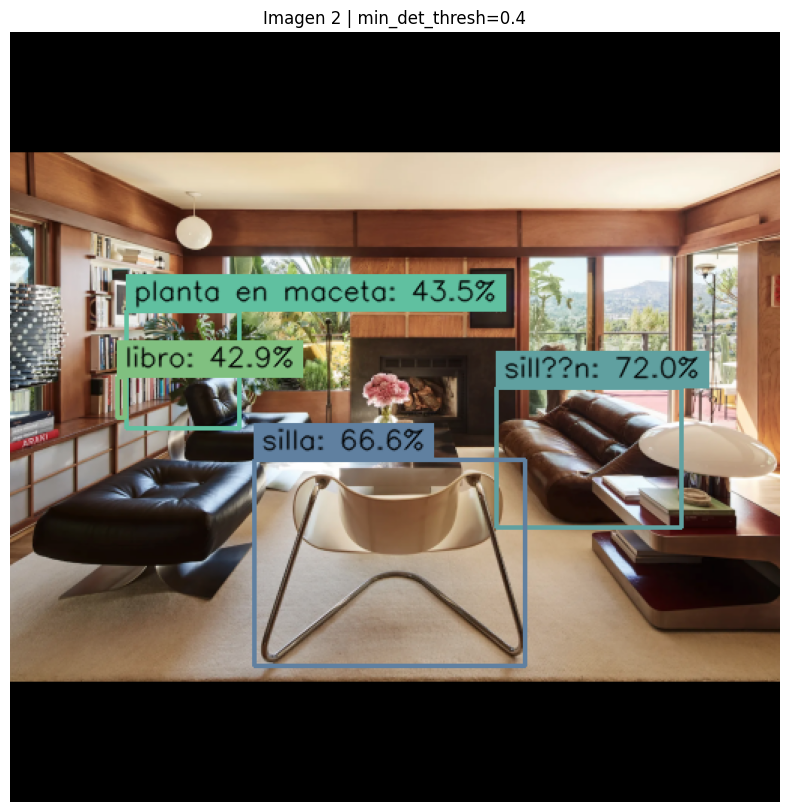

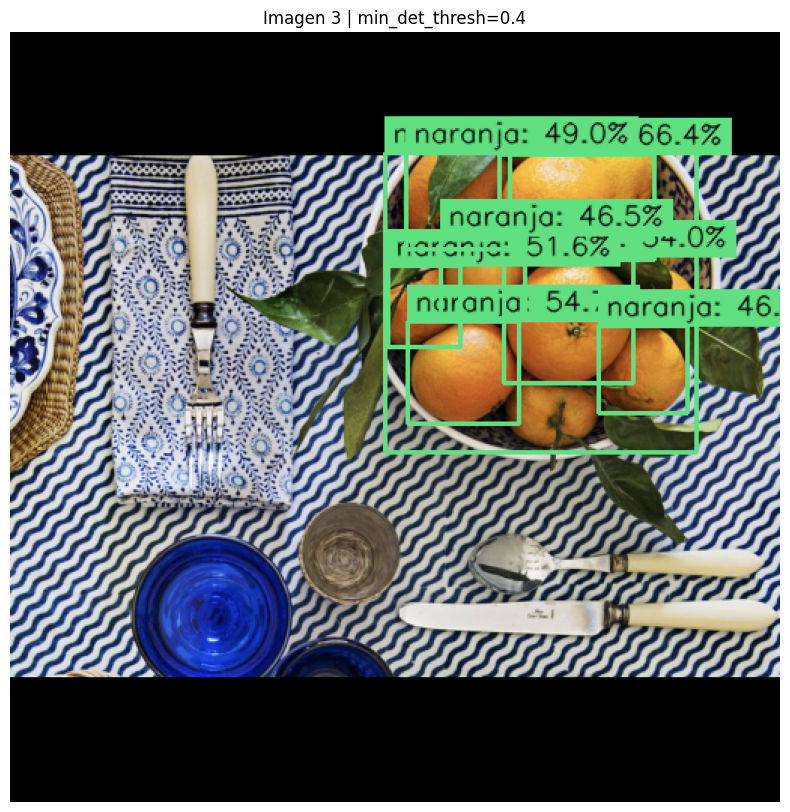

In [15]:
MIN_DET_THRESH = 0.4

results_list = run_inference(images_model, model)

for idx in range(len(images_model)):
    image = np.squeeze(images_model[idx])
    annotated = process_detection(image, results_list[idx], min_det_thresh=MIN_DET_THRESH)

    plt.figure(figsize=(16, 10))
    plt.title(f'Imagen {idx} | min_det_thresh={MIN_DET_THRESH}')
    plt.imshow(annotated)
    plt.axis('off')
    plt.show()


## 10) Subi tus propias fotos desde la PC

Si querés probar con tus imágenes:
1) Subís jpg/png desde tu compu
2) Se preparan al input del modelo (letterbox)
3) Se corre `run_inference` y se dibujan los boxes


Saving image_test.jpeg to image_test (6).jpeg
Imágenes subidas: ['image_test (6).jpeg']


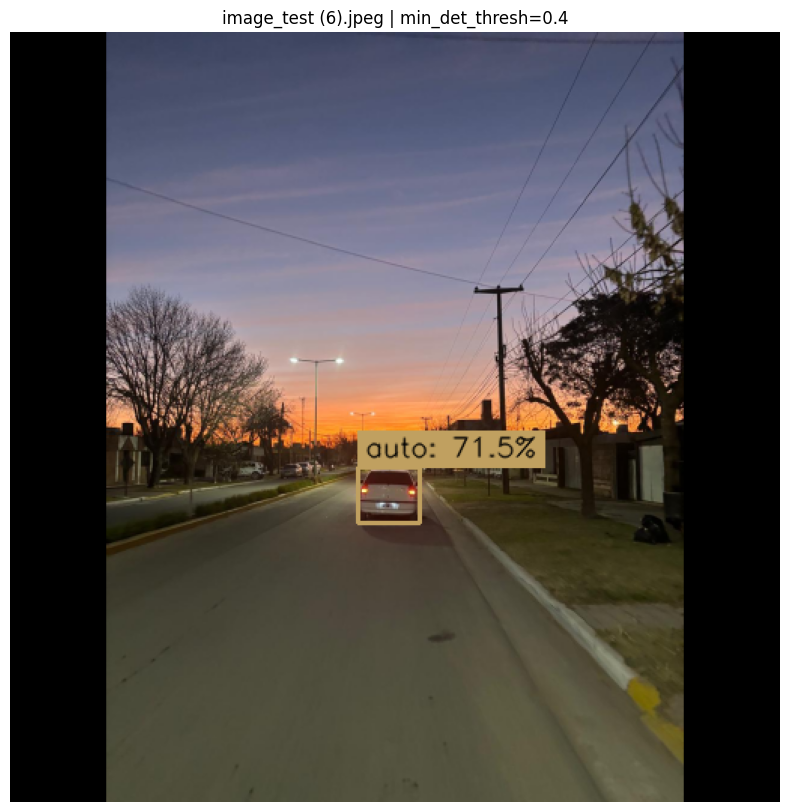

In [23]:
from google.colab import files

uploaded = files.upload()

user_paths = []
for name in uploaded.keys():
    ext = name.split('.')[-1].lower()
    if ext in ('jpg','jpeg','png','webp'):
        user_paths.append(name)
    else:
        print(f"⚠️ Saltando '{name}' (extensión no soportada)")

user_paths = sorted(user_paths)
print('Imágenes subidas:', user_paths)

user_images = [load_image_for_model(p, input_size) for p in user_paths]

# Inferencia + display
if user_images:
    user_results = run_inference(user_images, model)

    for i in range(len(user_images)):
        img = np.squeeze(user_images[i])
        ann = process_detection(img, user_results[i], min_det_thresh=MIN_DET_THRESH)

        plt.figure(figsize=(16, 10))
        plt.title(f'{user_paths[i]} | min_det_thresh={MIN_DET_THRESH}')
        plt.imshow(ann)
        plt.axis('off')
        plt.show()
